In [8]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#sets the random seed
tf.random.set_seed(1234)

In [9]:
#Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


In [10]:
#download and extract the "ModelNet10" datase
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [11]:
#load and visualize a 3D mesh file
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0003.off"))
mesh.show()

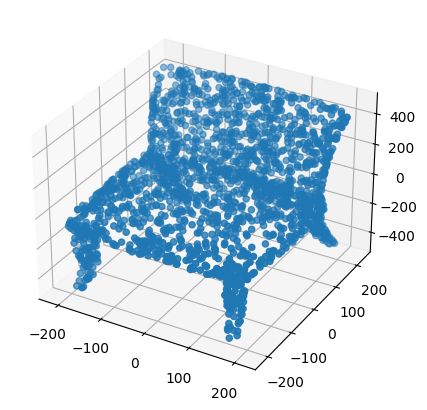

In [12]:
#sampling points from a 3D mesh and visualizing them using matplotlib.
points = mesh.sample(2048)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#ax.set_axis_off()
plt.show()

In [13]:
#parse_dataset function to process the "ModelNet10" dataset and prepare it for training and testing a machine learning model
def parse_dataset(num_points=2048):
    
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        #store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        #gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
            
            
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
            
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )
                               

In [14]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: table
processing class: sofa
processing class: bed
processing class: toilet
processing class: dresser
processing class: desk
processing class: bathtub
processing class: chair
processing class: night_stand
processing class: monitor


In [15]:
# creates TensorFlow Dataset objects
def augment(points, label):
    #jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    #shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))


train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

2023-06-19 13:05:33.811502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 13:05:33.962879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 13:05:33.982955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 13:05:33.983136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [16]:
# implement convolutional and dense layers with batch normalization and ReLU activation.
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [17]:
# defines a custom orthogonal regularizer in Keras
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        
        
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes = (2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [18]:
# implements the T-Net module.
def tnet(inputs, num_features):
    
    #initialise bias on the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [19]:
# defines a PointNet model using the Keras functional API
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [20]:
# compiles and trains the PointNet model using the specified loss function, optimizer, and metrics.
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20


2023-06-19 13:05:42.778411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-19 13:05:44.423265: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-19 13:05:44.424442: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-19 13:05:44.424462: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-19 13:05:44.424946: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-19 13:05:44.424992: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-19 13:05:44.789620: I tensorflow/stream_executor/cuda/c

125/125 [==============================] - 69s 496ms/step - loss: 3.5261 - sparse_categorical_accuracy: 0.2866 - val_loss: 8160327761920.0000 - val_sparse_categorical_accuracy: 0.2401
Epoch 2/20
125/125 [==============================] - 61s 489ms/step - loss: 3.0069 - sparse_categorical_accuracy: 0.3871 - val_loss: 76550291456.0000 - val_sparse_categorical_accuracy: 0.2026
Epoch 3/20
125/125 [==============================] - 61s 489ms/step - loss: 2.6885 - sparse_categorical_accuracy: 0.4944 - val_loss: 54638992687104.0000 - val_sparse_categorical_accuracy: 0.5727
Epoch 4/20
125/125 [==============================] - 61s 489ms/step - loss: 2.4369 - sparse_categorical_accuracy: 0.5740 - val_loss: 35631367454720.0000 - val_sparse_categorical_accuracy: 0.5738
Epoch 5/20
125/125 [==============================] - 61s 490ms/step - loss: 2.3910 - sparse_categorical_accuracy: 0.5921 - val_loss: 207629238272.0000 - val_sparse_categorical_accuracy: 0.6322
Epoch 6/20
125/125 [=================

1/1 [==============================] - 1s 526ms/step


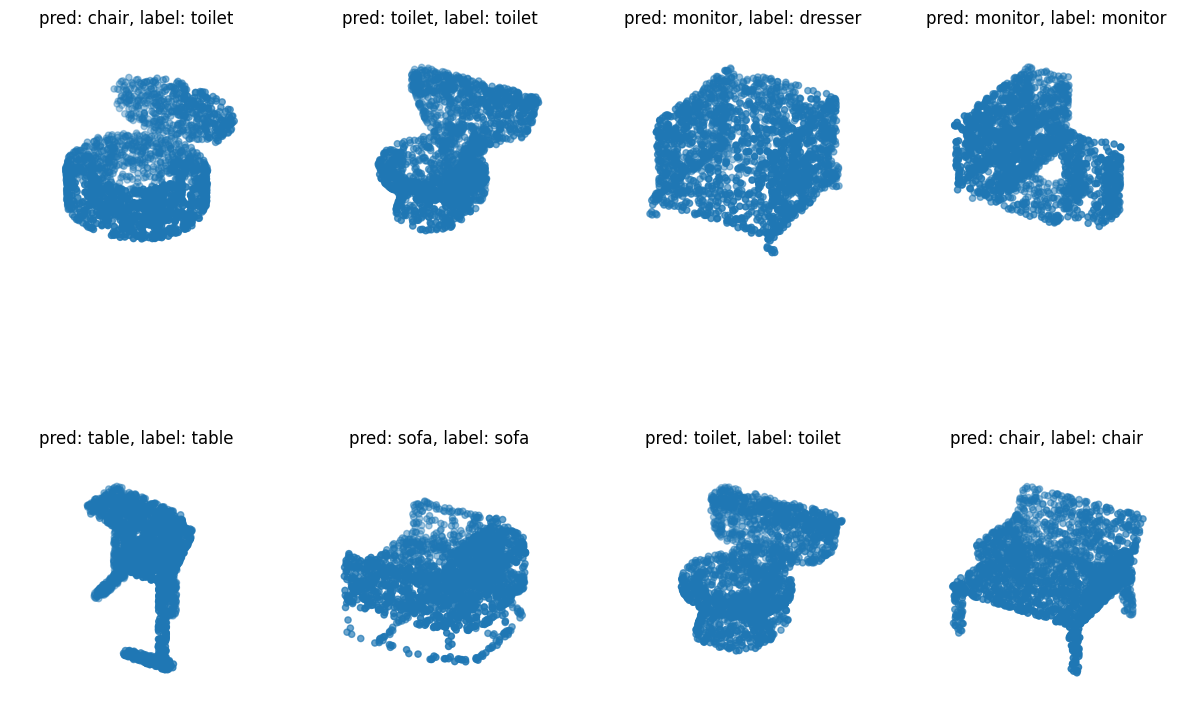

In [21]:
# evaluates the trained PointNet model on a small subset of the test dataset and visualizes the predictions. 
data = test_dataset.take(3)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

#plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, projection = "3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()